In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch


In [2]:
def combine_md_datetime(df, date_col='MDDate', time_col='MDTime', new_col='DateTime',drop_original=True):
    """
    日期和时间合并为标准datetime
    """
    df[date_col] = df[date_col].astype(str)
    df[time_col] = df[time_col].astype(str).str.zfill(9)
    datetime_str = df[date_col] + ' ' + df[time_col].str[:6]
    df[new_col] = pd.to_datetime(datetime_str, format='%Y%m%d %H%M%S')
    
    if drop_original:
        df.drop(columns=[date_col, time_col], inplace=True)
    return df

In [3]:
# 数据
etf = pd.read_csv("../data/518880.SH_20250101_20250630.csv",usecols=['MDDate','MDTime','LastPx','Buy1Price','Sell1Price'])
au = pd.read_csv("../data/AU99.99.SGE_20250101_20250630.csv",usecols=['MDDate','MDTime', 'LastPx','Buy1Price','Sell1Price'])

#清洗
#区分价格
etf.rename(columns={'LastPx': 'ETF_Price','Buy1Price':'ETF_Buy1Price','Sell1Price':'ETF_Sell1Price'}, inplace=True)
au.rename(columns={'LastPx': 'AU_Price','Buy1Price':'AU_Buy1Price','Sell1Price':'AU_Sell1Price'}, inplace=True)

#删去0值
etf = etf[etf['ETF_Price'] != 0]
au = au[au['AU_Price'] != 0]

#时间规范
etf = combine_md_datetime(etf)
au = combine_md_datetime(au)

#对齐
merged = pd.merge_asof(etf,au,on='DateTime',direction='backward')

In [4]:
etf_prices = merged['ETF_Price'].values
au_prices = merged['AU_Price'].values


In [5]:
#归一化 ===
etf_min, etf_max = etf_prices.min(), etf_prices.max()
au_min, au_max = au_prices.min(), au_prices.max()
etf_scaled = (etf_prices - etf_min) / (etf_max - etf_min)
au_scaled = (au_prices - au_min) / (au_max - au_min)


In [8]:
#LSTM样本
sequence_length = 20
X, au_now, y_real = [], [], []

for i in range(sequence_length, len(au_scaled)):
    X.append(au_scaled[i-sequence_length:i])
    au_now.append(au_scaled[i])                 # 当前AU价格
    y_real.append(etf_scaled[i])                # 当前ETF价格

X = torch.tensor(X).float().unsqueeze(-1)       # (N, 20, 1)
au_now = torch.tensor(au_now).float().unsqueeze(-1)  # (N, 1)
y_real = torch.tensor(y_real).float().unsqueeze(-1)  # (N, 1)


/var/folders/l7/tn6pwj1d2r53myncg5mkghpm0000gn/T/ipykernel_15735/3217282126.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  X = torch.tensor(X).float().unsqueeze(-1)       # (N, 20, 1)


In [9]:
dataset = TensorDataset(X, au_now, y_real)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


In [10]:
class BetaLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=32, batch_first=True)
        self.fc = nn.Linear(32, 1)  # 输出 β

    def forward(self, x, au_now):
        out, _ = self.lstm(x)
        beta = self.fc(out[:, -1, :])      # (N, 1)
        y_hat = beta * au_now              # 用当前AU价格还原ETF价格
        return y_hat, beta

In [11]:
model = BetaLSTM()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

In [12]:
#训练
for epoch in range(5):
    for xb, au_now_b, yb in dataloader:
        y_hat, _ = model(xb, au_now_b)
        loss = loss_fn(y_hat, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")

Epoch 1, Loss: 0.000015
Epoch 2, Loss: 0.000023
Epoch 3, Loss: 0.000021
Epoch 4, Loss: 0.000036
Epoch 5, Loss: 0.000028


In [13]:
#预测
model.eval()
with torch.no_grad():
    y_pred_scaled, beta_pred = model(X, au_now)

In [14]:
#还原
etf_pred = y_pred_scaled.squeeze().numpy() * (etf_max - etf_min) + etf_min
etf_real = etf_prices[sequence_length:]
residuals = etf_real - etf_pred
beta_pred_np = beta_pred.squeeze().numpy()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Framewo

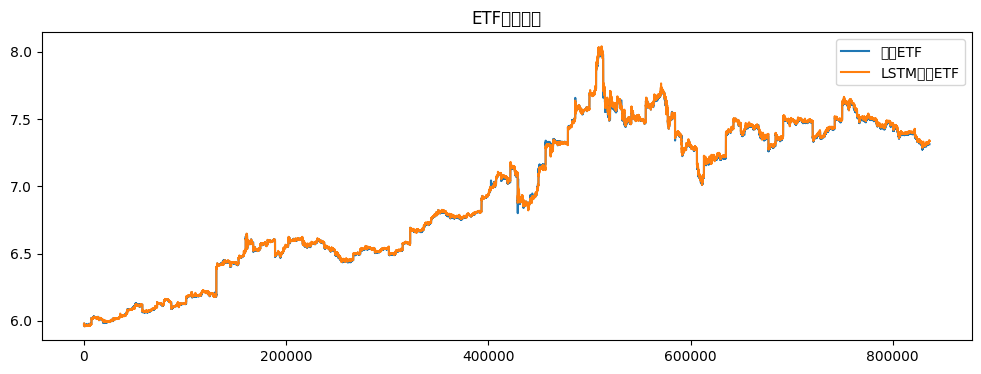

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27531 (\N{CJK UNIFIED IDEOGRAPH-6B8B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24207 (\N{CJK UNIFIED IDEOGRAPH-5E8F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21015 (\N{CJK UNIFIED IDEOGRAPH-5217}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


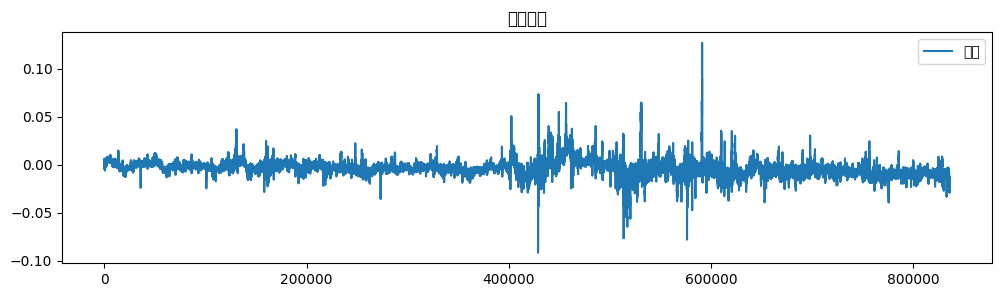

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21160 (\N{CJK UNIFIED IDEOGRAPH-52A8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24577 (\N{CJK UNIFIED IDEOGRAPH-6001}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


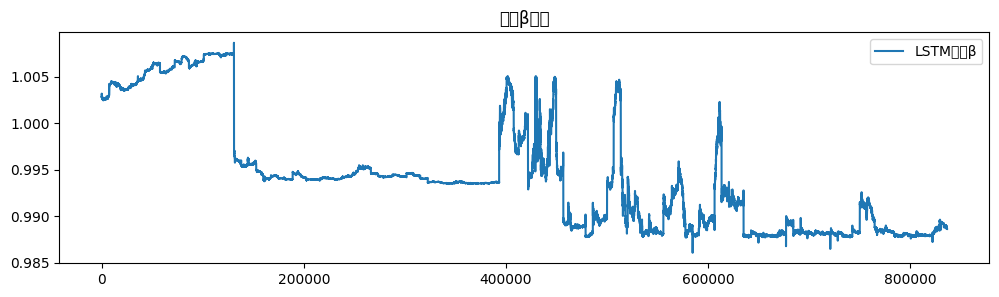

In [15]:
#可视化
plt.figure(figsize=(12, 4))
plt.plot(etf_real, label='真实ETF')
plt.plot(etf_pred, label='LSTM估计ETF')
plt.legend()
plt.title("ETF价格对比")
plt.show()

plt.figure(figsize=(12, 3))
plt.plot(residuals, label='残差')
plt.title("残差序列")
plt.legend()
plt.show()

plt.figure(figsize=(12, 3))
plt.plot(beta_pred_np, label='LSTM估计β')
plt.title("动态β序列")
plt.legend()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27531 (\N{CJK UNIFIED IDEOGRAPH-6B8B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 28378 (\N{CJK UNIFIED IDEOGRAPH-6EDA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Framewo

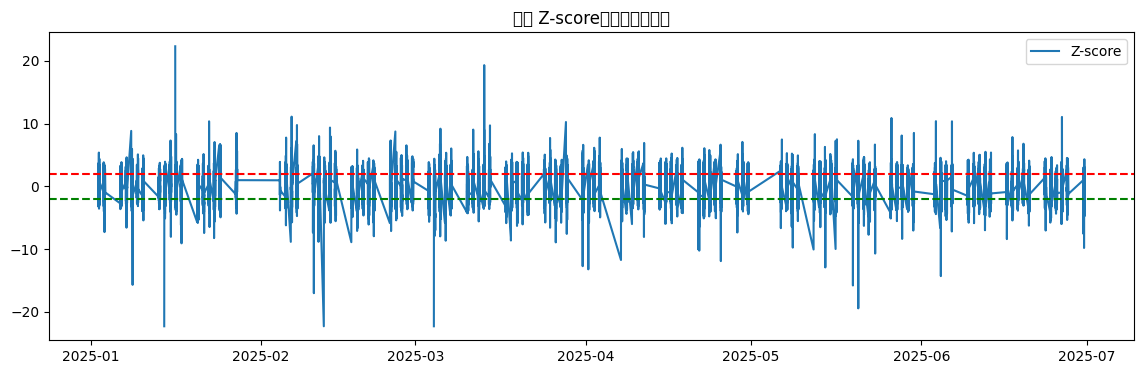

In [17]:
# 将 residuals 和时间对应起来
residuals_df = merged.iloc[sequence_length:].copy()
residuals_df['residual'] = residuals
residuals_df['beta'] = beta_pred_np

# === 滚动计算zscore（用500个tick窗口） ===
window = 500
residuals_df['residual_mean'] = residuals_df['residual'].rolling(window).mean()
residuals_df['residual_std'] = residuals_df['residual'].rolling(window).std()
residuals_df['zscore'] = (residuals_df['residual'] - residuals_df['residual_mean']) / residuals_df['residual_std']

# === 可视化 ===
plt.figure(figsize=(14, 4))
plt.plot(residuals_df['DateTime'], residuals_df['zscore'], label='Z-score')
plt.axhline(2, color='red', linestyle='--')
plt.axhline(-2, color='green', linestyle='--')
plt.title("残差 Z-score（滚动标准化）")
plt.legend()
plt.show()